<a href="https://colab.research.google.com/github/sey323/KinectMusicGame/blob/master/probspace_200122.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pwd

/content


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# データの読み込み
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

print(train_df.shape, test_df.shape)

(21000, 13) (9000, 12)


In [3]:
test_df.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime
0,0,3,39,鹿児島県,2,1,5,1,19,1.0,1.8,14.2
1,1,1,31,宮城県,1,0,0,4,0,0.0,0.5,18.6
2,2,0,20,愛知県,2,1,2,0,2,2.0,1.2,2.3
3,3,0,28,三重県,2,0,0,0,10,3.0,0.3,0.0
4,4,1,41,愛媛県,2,0,0,0,23,3.0,0.5,10.1


In [4]:
# データの統計情報を表示
train_df.describe()

,id,position,age,sex,partner,num_child,education,service_length,study_time,commute,overtime,salary
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,10499.500000,1.226857,33.132476,1.498333,0.499333,0.999667,1.098571,12.303143,3.828476,1.059910,12.126752,361.170391
std,6062.322162,1.224682,10.715241,0.500009,0.500011,1.417459,1.116355,10.696823,3.312927,0.665307,5.509408,171.618501
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,110.622310
25%,5249.750000,0.000000,24.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.500000,8.300000,225.498117
50%,10499.500000,1.000000,30.000000,1.000000,0.000000,0.000000,1.000000,9.000000,3.000000,1.100000,12.100000,315.224583
75%,15749.250000,2.000000,42.000000,2.000000,1.000000,2.000000,2.000000,21.000000,6.000000,1.500000,15.800000,456.927443
max,20999.000000,4.000000,67.000000,2.000000,1.000000,9.000000,4.000000,49.000000,24.000000,4.800000,31.900000,1098.943632


In [5]:
train_df.columns

Index(['id', 'position', 'age', 'area', 'sex', 'partner', 'num_child',
       'education', 'service_length', 'study_time', 'commute', 'overtime',
       'salary'],
      dtype='object')

# データ分析

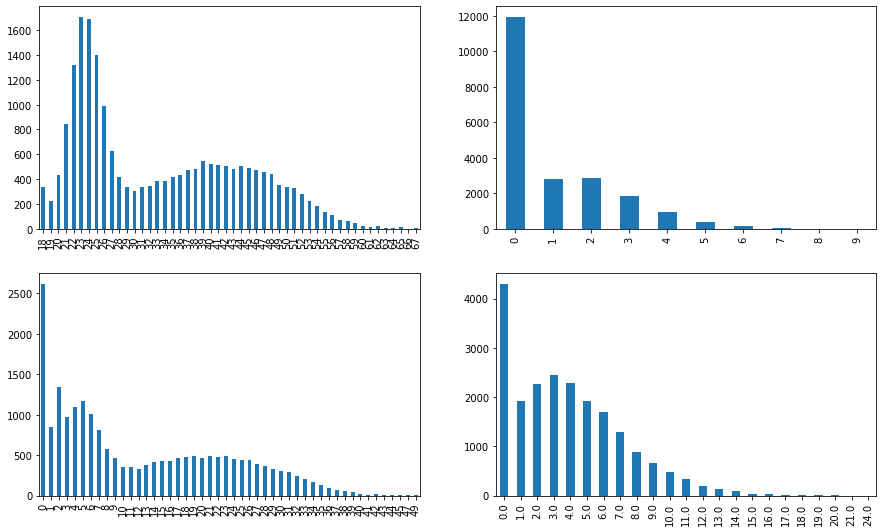

In [6]:
# 棒グラフを複数表示
fig, ax = plt.subplots(2, 2, figsize=(15, 9))

train_df["age"].value_counts().sort_index().plot.bar(ax=ax[0][0]) # 年齢
train_df["num_child"].value_counts().sort_index().plot.bar(ax=ax[0][1]) # 子供の数
train_df["service_length"].value_counts().sort_index().plot.bar(ax=ax[1][0]) # 勤続年数
train_df["study_time"].value_counts().sort_index().plot.bar(ax=ax[1][1]) # 勉強時間

## 特徴量加工

In [7]:
# 教師データを説明変数と目的変数に分割
train_x, train_y = train_df.drop("salary", axis=1), train_df["salary"]
train_x.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime
0,0,1,44,愛知県,2,1,2,1,24,2.0,1.6,9.2
1,1,2,31,奈良県,1,0,0,0,13,9.0,0.7,12.4
2,2,2,36,山口県,1,0,0,2,14,4.0,0.4,16.9
3,3,0,22,東京都,2,0,0,0,4,3.0,0.4,6.1
4,4,0,25,鹿児島県,2,0,0,1,5,3.0,0.2,4.9


In [0]:
def label_encorde(data_col):
    '''
    data_col     : 対象のデータフレームの１つの列
    '''
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le = le.fit(data_col)
    #ラベルを整数に変換
    data_col = le.transform(data_col)

    return data_col


def log_convert(df, column_name):
    '''
    対数変換により偏りのある分布を正規分布に近づける
    '''
    df[column_name + "_log"] = df[column_name].apply(np.log1p)
    return df

In [0]:
def binning(df, column_name, bin_ranges, bin_labels):
    '''
    与えられたbin情報に従ってbinning
    '''
    df[column_name + '_bin']= pd.cut(df[column_name], bins=bin_ranges, labels=bin_labels)
    df[column_name + "_bin"] = label_encorde(df[column_name + "_bin"])

    return df

In [0]:
def preprocess(df):
  '''
  前処理を行う
  Parameters
  -----
    df : padnas.Dataframe
      対象のデータフレーム
  '''
  # IDを取り除く
  df = df.drop("id", axis=1)
  df["area"] = label_encorde(df['area'])

  # 数値データ→カテゴリデータ
  # 年齢→年代
  age_bin_range = [0, 24, 30, 40, 50, 100]
  age_bin_labels = ['(18-24]', '(25-30]', '(31-40]', '(41-50]', '(51-']
  df = binning(df, "age", age_bin_range, age_bin_labels)
  
  # 子供の人数
  child_bin_ranges = [-1, 0, 2, 10]
  child_bin_labels = ['0', '1~2', "3~"]
  df = binning(df, "num_child", child_bin_ranges, child_bin_labels)
  
  # 就業年数
  sl_bin_ranges = [-1, 1, 5, 10, 15, 20, 30, 40, 100]
  sl_bin_labels = ['0~1', '2~5', '6~10', '11~15', '16~20', '21~30', "31~40", "41~100"]
  df = binning(df, "service_length", sl_bin_ranges, sl_bin_labels)

  # 人生の何％をその会社に尽くしたか
  df["service_rate"] = df["service_length"] / df["age"]

  # 対数変換
  # df = log_convert(df, "study_time")

  return df

In [0]:
all_x = pd.concat([train_x, test_df])
preprocessed_all_x = preprocess(all_x)

# 前処理を行なったデータを，学習データとテストデータに再分割
preprocessed_train_x, preprocessed_test_x = preprocessed_all_x[:train_x.shape[0]], preprocessed_all_x[train_x.shape[0]:]

## モデルの作成

In [0]:
# LightGBM
import lightgbm as lgb

# コードの動作を確認するためのモデル
class lightGBM:
    def __init__(self, params=None):
        self.model = None
        if params is not None:
            self.params = params
        else:
            self.params = {'objective':'regression',
                          'seed': 0,
                          'verbose':10, 
                          'boosting_type': 'gbdt',
                          'metrics':'mae', 
                          'learning_rate':0.01, 
                          'drop_rate':0.5
                         }
        self.num_round = 30000
        self.early_stopping_rounds = 100
        self.target_columms = []


    def fit(self, tr_x, tr_y, va_x, va_y):
        self.target_columms = tr_x.columns

        # データセットを変換
        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_eval = lgb.Dataset(va_x, va_y)

        print(self.target_columms)
        print(self.params)

        self.model = lgb.train(self.params, 
                               lgb_train, 
                               num_boost_round=self.num_round,
                               early_stopping_rounds=self.early_stopping_rounds,
                               valid_names=['train', 'valid'],
                               valid_sets=[lgb_train, lgb_eval],
                               verbose_eval=200
                              )
        

    def predict(self, x):
        data = lgb.Dataset(x)
        pred = self.model.predict(x, num_iteration=self.model.best_iteration)
        return pred


    def print_feature(self, target_columms=None):
        '''
        特徴量の出力
        '''
        if target_columms is not None:
            self.target_columms = target_columms
        feature_imp = pd.DataFrame(sorted(zip(self.model.feature_importance(), self.target_columms)), columns=['Value','Feature'])
        print(feature_imp)

In [0]:
# テストデータの分割
from sklearn.model_selection import train_test_split
tr_x, va_x, tr_y, va_y = train_test_split(preprocessed_train_x, train_y, test_size=0.2, random_state=777)

In [14]:
# 学習の実行，バリデーションデータの予測値の出力，スコアの計算を行う
model = lightGBM()
model.fit(tr_x, tr_y, va_x, va_y)
pred = model.predict(va_x)

Index(['position', 'age', 'area', 'sex', 'partner', 'num_child', 'education',
       'service_length', 'study_time', 'commute', 'overtime', 'age_bin',
       'num_child_bin', 'service_length_bin', 'service_rate'],
      dtype='object')
{'objective': 'regression', 'seed': 0, 'verbose': 10, 'boosting_type': 'gbdt', 'metrics': 'mae', 'learning_rate': 0.01, 'drop_rate': 0.5}
Training until validation scores don't improve for 100 rounds.
[200]	train's l1: 36.4813	valid's l1: 38.1641
[400]	train's l1: 25.4594	valid's l1: 27.7413
[600]	train's l1: 22.943	valid's l1: 25.4963
[800]	train's l1: 21.9326	valid's l1: 24.7903
[1000]	train's l1: 21.3163	valid's l1: 24.4767
[1200]	train's l1: 20.8102	valid's l1: 24.2436
[1400]	train's l1: 20.374	valid's l1: 24.1136
[1600]	train's l1: 19.9719	valid's l1: 23.9562
[1800]	train's l1: 19.586	valid's l1: 23.8382
[2000]	train's l1: 19.2495	valid's l1: 23.7683
[2200]	train's l1: 18.9177	valid's l1: 23.6805
[2400]	train's l1: 18.6259	valid's l1: 23.6464
[2600]

In [15]:
# 学習した特徴量の重要度を見る
model.print_feature()

    Value             Feature
0       0             age_bin
1       0       num_child_bin
2     953  service_length_bin
3    1359                 sex
4    2403             partner
5    3426      service_length
6    4526           num_child
7    5211            position
8    5340          study_time
9    5469           education
10   6786        service_rate
11   7747                 age
12   9837                area
13  11767            overtime
14  16416             commute


## 結果を元に再び特徴量加工

In [0]:
def after_preprocess(df):
  '''
  特徴量の重要度から再び特徴量作成
  '''
  df = df.drop(["age_bin", "num_child_bin"], axis=1)

  # 残業時間
  overtime_bin_ranges = [-1, 0, 5, 10, 20, 30, 40]
  overtime_bin_labels = ["0", "1~5", "6~10", "11~20", "21~30", "30~"]
  df = binning(df, "overtime", overtime_bin_ranges, overtime_bin_labels)
  
  return df

In [17]:
all_x2 = pd.concat([preprocessed_train_x, preprocessed_test_x])
preprocessed_all_x2 = after_preprocess(all_x2)

# 前処理を行なったデータを，学習データとテストデータに再分割
preprocessed_train_x2, preprocessed_test_x2 = preprocessed_all_x2[:train_x.shape[0]], preprocessed_all_x2[train_x.shape[0]:]
preprocessed_train_x2.head()

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,service_length_bin,service_rate,overtime_bin
0,1,44,24,2,1,2,1,24,2.0,1.6,9.2,3,0.545455,5
1,2,31,10,1,0,0,0,13,9.0,0.7,12.4,1,0.419355,1
2,2,36,14,1,0,0,2,14,4.0,0.4,16.9,1,0.388889,1
3,0,22,26,2,0,0,0,4,3.0,0.4,6.1,4,0.181818,5
4,0,25,46,2,0,0,1,5,3.0,0.2,4.9,4,0.200000,2


In [0]:
# テストデータの分割
tr_x2, va_x2, tr_y2, va_y2 = train_test_split(preprocessed_train_x2, train_y, test_size=0.2, random_state=777)

In [19]:
# 学習の実行，バリデーションデータの予測値の出力，スコアの計算を行う
model2 = lightGBM()
model2.fit(tr_x2, tr_y2, va_x2, va_y2)
pred = model2.predict(va_x)

Index(['position', 'age', 'area', 'sex', 'partner', 'num_child', 'education',
       'service_length', 'study_time', 'commute', 'overtime',
       'service_length_bin', 'service_rate', 'overtime_bin'],
      dtype='object')
{'objective': 'regression', 'seed': 0, 'verbose': 10, 'boosting_type': 'gbdt', 'metrics': 'mae', 'learning_rate': 0.01, 'drop_rate': 0.5}
Training until validation scores don't improve for 100 rounds.
[200]	train's l1: 36.4813	valid's l1: 38.1641
[400]	train's l1: 25.4288	valid's l1: 27.7013
[600]	train's l1: 22.9217	valid's l1: 25.4238
[800]	train's l1: 21.8916	valid's l1: 24.6767
[1000]	train's l1: 21.2889	valid's l1: 24.3713
[1200]	train's l1: 20.7866	valid's l1: 24.1508
[1400]	train's l1: 20.3496	valid's l1: 24.0189
[1600]	train's l1: 19.965	valid's l1: 23.9165
[1800]	train's l1: 19.5854	valid's l1: 23.8035
[2000]	train's l1: 19.2255	valid's l1: 23.6992
[2200]	train's l1: 18.9102	valid's l1: 23.6555
[2400]	train's l1: 18.6427	valid's l1: 23.6434
[2600]	train's l

In [20]:
# 改めて特徴量の重要度を確認
model2.print_feature()

    Value             Feature
0     706        overtime_bin
1    1110  service_length_bin
2    1564                 sex
3    2612             partner
4    4037      service_length
5    4909           num_child
6    5719           education
7    5767            position
8    6565          study_time
9    7635        service_rate
10   8763                 age
11  11551                area
12  13517            overtime
13  18155             commute


## 提出ファイルの作成

In [0]:
# テスト用のモデルの評価
proba = model.predict(preprocessed_test_x)

In [22]:
# テストデータの作成
submit_df = pd.DataFrame(test_df['id'])
submit_df[1] = proba
submit_df.head()

,id,1
0,0,525.948327
1,1,275.934738
2,2,207.177579
3,3,164.942983
4,4,303.477688


In [0]:
submit_df.to_csv('submit.csv',header=['id','y'],index=False)